I was working in Google colab to have more available RAM. 

### Library installation, google drive preparation, library import

In [ ]:
%pip install -U lightgbm==3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle
from tqdm import tqdm
import gc
from pathlib import Path
from matplotlib.pyplot import figure

figure(figsize=(2, 3), dpi=80)

In [ ]:
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/AIproj/git_proj/HM/") # path to the src folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

import random
random.seed(42)

Custom functions import 

In [ ]:
from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
    mean_average_precision,
)

In [ ]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k, precision_at_k

# functions for candidate generation 
from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)

from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale, purhcase_predictors

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
    precision_at_k,
)

In [ ]:
data_dir = Path("/content/drive/MyDrive/AIproj/data/")
model_dir = Path("/content/drive/MyDrive/AIproj/git_proj/HM/models/")

In [ ]:
# set parameters
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "Recall_1"
TEST = True # * Set as `False` when do local experiments to save time

NUMBER_OF_WEEKS_TOTAL = 25 # total number of weeks that are used for model training and prediction calculation 

In [ ]:
# check that data folder exists 
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

### Data preparation: encoding ids and preprocessing

In [ ]:
# create an abject to read data 
dh = DataHelper(data_dir)
# data = dh.preprocess_data(save=True, name="encoded_full") # run only once, processed data will be saved
data = dh.load_data(name="encoded_full") # load preprocessed data

In [ ]:
# map ids to a shorter representation 
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
# read data 
user = data["user"]
item = data["item"]
inter = data["inter"]

# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
# delete duplicates 
inter = inter.drop_duplicates(['customer_id', 'article_id', 'week'], keep='first') 
# select only NUMBER_OF_WEEKS_TOTAL weeks 
inter = inter.loc[inter['week'] <= NUMBER_OF_WEEKS_TOTAL]
data["inter"] = inter

In [ ]:
## extra preprocessing for users and items 
# calculate purchase_ability of customers based on previous purchases 
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

# calculate age bins 
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

# column type transformation 
data['user']["FN"] = data['user']["FN"].astype('int8')
data['user']["Active"] = data['user']["Active"].astype('int8')

del user, item, inter

### Candidate generation for every week 
Generate candidates for training (weeks 1 and more)

In [ ]:

trans = data["inter"]
trans['t_dat'] = pd.to_datetime(trans['t_dat'])
for week in range(1, WEEK_NUM):
    # * use sliding window to generate candidates
    # calculate week dates 
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender', 'purchase_ability', 'age_bins']], on='customer_id', how='left')

    # generate daatsets of transactions for a defined number of weeks 
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # ========================== Retrieval Strategies ==========================
    # apply different option for candidate generation and their combination using a custom class 'RuleCollector'  
    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=50, iter_num=25),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=50, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=50, scale=True, name='3'),
            OrderHistory(train, days=35, n=50),
            OrderHistoryDecay(train, days=7, n=50),
            TimeHistory(customer_list, last_week, n=50),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],
        min_pos_rate=0.0, # use all candidates 
        norm=False,
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    # aggregation to a desirable format: customer_id, article_id and all rules 
    # all candidates are unique 
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    # score's scaling 
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    tmp = candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates['score'] = tmp[rule_names].sum(axis=1)
    del tmp
    gc.collect()
    # candidate ranking and selection of not more than 100 candidates per customer  
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=100]
    # save candidates 
    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate.pqt")
    # save real purchases during the next week 
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{week}_label.pqt")


Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   8%|▊         | 1/13 [05:47<1:09:32, 347.68s/it]

Positive rate: 0.00312


Retrieve items by rules:  15%|█▌        | 2/13 [05:50<26:35, 145.08s/it]  

Positive rate: 0.00455


Retrieve items by rules:  23%|██▎       | 3/13 [05:53<13:20, 80.03s/it] 

Positive rate: 0.00486


Retrieve items by rules:  31%|███       | 4/13 [05:56<07:24, 49.44s/it]

Positive rate: 0.00456
Positive rate: 0.01590


Retrieve items by rules:  38%|███▊      | 5/13 [06:04<04:37, 34.69s/it]

Positive rate: 0.01269


Retrieve items by rules:  46%|████▌     | 6/13 [06:17<03:11, 27.38s/it]

Positive rate: 0.00427


Retrieve items by rules:  54%|█████▍    | 7/13 [06:20<01:55, 19.18s/it]

Positive rate: 0.00845


Retrieve items by rules:  62%|██████▏   | 8/13 [07:10<02:25, 29.05s/it]

Positive rate: 0.00887


Retrieve items by rules:  69%|██████▉   | 9/13 [07:23<01:36, 24.01s/it]

Positive rate: 0.00811


Retrieve items by rules:  77%|███████▋  | 10/13 [08:18<01:40, 33.63s/it]

Positive rate: 0.00995


Retrieve items by rules:  85%|████████▍ | 11/13 [08:34<00:56, 28.17s/it]

Positive rate: 0.00822


Retrieve items by rules:  92%|█████████▏| 12/13 [09:32<00:37, 37.23s/it]

Positive rate: 0.00996


Retrieve items by rules: 100%|██████████| 13/13 [09:48<00:00, 45.25s/it]


0

Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   8%|▊         | 1/13 [05:45<1:09:06, 345.51s/it]

Positive rate: 0.00289


Retrieve items by rules:  15%|█▌        | 2/13 [05:49<26:27, 144.33s/it]  

Positive rate: 0.00395


Retrieve items by rules:  23%|██▎       | 3/13 [05:51<13:15, 79.54s/it] 

Positive rate: 0.00429
Positive rate: 0.00401


Retrieve items by rules:  31%|███       | 4/13 [05:54<07:22, 49.15s/it]

Positive rate: 0.01530


Retrieve items by rules:  38%|███▊      | 5/13 [06:02<04:35, 34.42s/it]

Positive rate: 0.01227


Retrieve items by rules:  46%|████▌     | 6/13 [06:15<03:10, 27.26s/it]

Positive rate: 0.00359


Retrieve items by rules:  54%|█████▍    | 7/13 [06:17<01:54, 19.08s/it]

Positive rate: 0.00807


Retrieve items by rules:  62%|██████▏   | 8/13 [07:09<02:26, 29.36s/it]

Positive rate: 0.00831


Retrieve items by rules:  69%|██████▉   | 9/13 [07:23<01:38, 24.67s/it]

Positive rate: 0.00765


Retrieve items by rules:  77%|███████▋  | 10/13 [08:30<01:52, 37.64s/it]

Positive rate: 0.00941


Retrieve items by rules:  85%|████████▍ | 11/13 [08:48<01:03, 31.82s/it]

Positive rate: 0.00779


Retrieve items by rules:  92%|█████████▏| 12/13 [09:49<00:40, 40.53s/it]

Positive rate: 0.00943


Retrieve items by rules: 100%|██████████| 13/13 [10:07<00:00, 46.77s/it]


0

Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   8%|▊         | 1/13 [05:57<1:11:27, 357.28s/it]

Positive rate: 0.00290


Retrieve items by rules:  15%|█▌        | 2/13 [06:00<27:21, 149.22s/it]  

Positive rate: 0.00433
Positive rate: 0.00459


Retrieve items by rules:  23%|██▎       | 3/13 [06:03<13:43, 82.37s/it] 

Positive rate: 0.00439


Retrieve items by rules:  31%|███       | 4/13 [06:07<07:43, 51.45s/it]

Positive rate: 0.01417


Retrieve items by rules:  38%|███▊      | 5/13 [06:16<04:49, 36.16s/it]

Positive rate: 0.01108


Retrieve items by rules:  46%|████▌     | 6/13 [06:29<03:18, 28.35s/it]

Positive rate: 0.00385


Retrieve items by rules:  54%|█████▍    | 7/13 [06:32<01:59, 19.87s/it]

Positive rate: 0.00791


Retrieve items by rules:  62%|██████▏   | 8/13 [07:29<02:38, 31.75s/it]

Positive rate: 0.00811


Retrieve items by rules:  69%|██████▉   | 9/13 [07:44<01:46, 26.60s/it]

Positive rate: 0.00740


Retrieve items by rules:  77%|███████▋  | 10/13 [08:45<01:51, 37.02s/it]

Positive rate: 0.00923


Retrieve items by rules:  85%|████████▍ | 11/13 [09:05<01:03, 31.79s/it]

Positive rate: 0.00753


Retrieve items by rules:  92%|█████████▏| 12/13 [10:11<00:42, 42.36s/it]

Positive rate: 0.00929


Retrieve items by rules: 100%|██████████| 13/13 [10:29<00:00, 48.45s/it]


0

Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   8%|▊         | 1/13 [06:00<1:12:06, 360.55s/it]

Positive rate: 0.00261


Retrieve items by rules:  15%|█▌        | 2/13 [06:04<27:36, 150.59s/it]  

Positive rate: 0.00433


Retrieve items by rules:  23%|██▎       | 3/13 [06:06<13:51, 83.11s/it] 

Positive rate: 0.00467
Positive rate: 0.00438


Retrieve items by rules:  31%|███       | 4/13 [06:09<07:42, 51.40s/it]

Positive rate: 0.01237


Retrieve items by rules:  38%|███▊      | 5/13 [06:19<04:49, 36.24s/it]

Positive rate: 0.00943


Retrieve items by rules:  46%|████▌     | 6/13 [06:31<03:17, 28.26s/it]

Positive rate: 0.00405


Retrieve items by rules:  54%|█████▍    | 7/13 [06:34<01:59, 19.85s/it]

Positive rate: 0.00702


Retrieve items by rules:  62%|██████▏   | 8/13 [07:35<02:45, 33.04s/it]

Positive rate: 0.00730


Retrieve items by rules:  69%|██████▉   | 9/13 [07:50<01:49, 27.47s/it]

Positive rate: 0.00672


Retrieve items by rules:  77%|███████▋  | 10/13 [08:54<01:55, 38.62s/it]

Positive rate: 0.00856


Retrieve items by rules:  85%|████████▍ | 11/13 [09:11<01:04, 32.08s/it]

Positive rate: 0.00664


Retrieve items by rules:  92%|█████████▏| 12/13 [10:16<00:41, 41.97s/it]

Positive rate: 0.00850


Retrieve items by rules: 100%|██████████| 13/13 [10:33<00:00, 48.77s/it]


0

Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   8%|▊         | 1/13 [05:57<1:11:26, 357.18s/it]

Positive rate: 0.00259


Retrieve items by rules:  15%|█▌        | 2/13 [06:00<27:19, 149.07s/it]  

Positive rate: 0.00358


Retrieve items by rules:  23%|██▎       | 3/13 [06:03<13:41, 82.14s/it] 

Positive rate: 0.00421
Positive rate: 0.00374


Retrieve items by rules:  31%|███       | 4/13 [06:05<07:36, 50.67s/it]

Positive rate: 0.01385


Retrieve items by rules:  38%|███▊      | 5/13 [06:13<04:42, 35.36s/it]

Positive rate: 0.01038


Retrieve items by rules:  46%|████▌     | 6/13 [06:26<03:14, 27.84s/it]

Positive rate: 0.00341


Retrieve items by rules:  54%|█████▍    | 7/13 [06:29<01:56, 19.46s/it]

Positive rate: 0.00689


Retrieve items by rules:  62%|██████▏   | 8/13 [07:40<03:00, 36.05s/it]

Positive rate: 0.00683


Retrieve items by rules:  69%|██████▉   | 9/13 [07:56<01:58, 29.62s/it]

Positive rate: 0.00645


Retrieve items by rules:  77%|███████▋  | 10/13 [09:07<02:07, 42.54s/it]

Positive rate: 0.00806


Retrieve items by rules:  85%|████████▍ | 11/13 [09:26<01:10, 35.25s/it]

Positive rate: 0.00653


Retrieve items by rules:  92%|█████████▏| 12/13 [10:38<00:46, 46.33s/it]

Positive rate: 0.00824


Retrieve items by rules: 100%|██████████| 13/13 [10:56<00:00, 50.48s/it]


0

In [ ]:
# candidate generation for the last week (to create Kaggle prediction)
# part 1 with 9 rules (couldn't run for all customers and rules because of memory limitations)
# the same as for other weeks 
trans = data["inter"]
trans['t_dat'] = pd.to_datetime(trans['t_dat'])
week = 0 

start_date, end_date = calc_valid_date(week)
print(f"Week {week}: [{start_date}, {end_date})")

train, valid = dh.split_data(trans, start_date, end_date)
train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
train = train.merge(user_info, on='customer_id', how='left')

last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]

if week != 0:
    customer_list = valid["customer_id"].values
else:
    customer_list = submission['customer_id'].values

# * ========================== Retrieval Strategies ==========================

candidates = RuleCollector().collect(
    week_num = week,
    trans_df = trans,
    customer_list=customer_list,
    rules=[
        ALS(customer_list, last_60day, n=50, iter_num=25),
        UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, scale=True, name='1'),
        UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=50, scale=True, name='2'),
        UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=50, scale=True, name='3'),
        OrderHistory(train, days=35, n=50),
        OrderHistoryDecay(train, days=7, n=50),
        TimeHistory(customer_list, last_week, n=50),
        ItemCF(last_60day, last_2week, top_k=10, name='2'),
        ItemCF(last_2week, last_2week, top_k=10, name='3'),
    ],
    min_pos_rate=0.0,
    norm=False,
    compress=False,
)

candidates, _ = reduce_mem_usage(candidates)
# candidates = (
#     pd.pivot_table(
#         candidates,
#         values="score",
#         index=["customer_id", "article_id"],
#         columns=["method"],
#         aggfunc=np.sum,
#     )
#     .reset_index()
# )
# rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
# tmp = candidates[rule_names]
# for f in rule_names:
#     tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
# candidates['score'] = tmp[rule_names].sum(axis=1)
# del tmp
# gc.collect()
# candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
# candidates = candidates[candidates['rank']<=100]
candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate_part1.pqt")
valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{week}_label.pqt")


Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 9/9 [09:15<00:00, 61.76s/it]


finished
finished


In [ ]:
# candidate generation for the last week (to create Kaggle prediction)
# part 2 with 9 rules (couldn't run for all customers and rules because of memory limitations)
# the same as for other weeks 
trans = data["inter"]
trans['t_dat'] = pd.to_datetime(trans['t_dat'])
week = 0 

start_date, end_date = calc_valid_date(week)
print(f"Week {week}: [{start_date}, {end_date})")

train, valid = dh.split_data(trans, start_date, end_date)
train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
train = train.merge(user_info, on='customer_id', how='left')

last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]

if week != 0:
    customer_list = valid["customer_id"].values
else:
    customer_list = submission['customer_id'].values

# * ========================== Retrieval Strategies ==========================

candidates = RuleCollector().collect(
    week_num = week,
    trans_df = trans,
    customer_list=customer_list,
    rules=[
        UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
        UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
        UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
        UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
    ],
    min_pos_rate=0.0,
    norm=False,
    compress=False,
)

candidates, _ = reduce_mem_usage(candidates)
candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate_part2.pqt")
# valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{week}_label.pqt")


Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 4/4 [02:18<00:00, 34.55s/it]


finished
finished


In [ ]:
del candidates

In [ ]:
# combine candidates for the last week 
week = 0
candidates1 = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate_part1.pqt")
candidates2 = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate_part2.pqt")
candidates1 = candidates1.append(candidates2)
del candidates2

candidates1 = (
    pd.pivot_table(
        candidates1,
        values="score",
        index=["customer_id", "article_id"],
        columns=["method"],
        aggfunc=np.sum,
    )
    .reset_index()
)
candidates1.to_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate_part12.pqt")

#### Candidate analyses in terms of future purchases

In [ ]:
# calculate recall@100 for all the candidates within 5 weeks for every candidate generation method 
recalls = {}
for week in range(1, WEEK_NUM):
  # read candidates and labels for them for all training weeks 
  candidates = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{week}_candidate.pqt")
  valid = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{week}_label.pqt")

  # select only candidates with purchases in future 
  new_candidates = candidates[candidates['customer_id'].isin(valid['customer_id'])] 
  # gel all columns with candidates 
  method_cols = new_candidates.columns[~new_candidates.columns.isin(['customer_id', 'article_id', 'score']) ]
  print(week)
  # recall calculation 
  for col in method_cols:
    v = new_candidates[new_candidates[col].notna()].groupby(["customer_id"])['article_id'].apply(list).reset_index()
    recall_value = recall_at_k(valid['article_id'], v['article_id'], k=100)
    if col in recalls:
      recalls[col].append(recall_value)
    else: 
      recalls[col] = [recall_value]

1
2
3
4
5


In [ ]:
# calculate means and stds for 5 weeks 
means = []
stds = []
for k,v in recalls.items():
  means.append(np.mean(v))
  stds.append(np.std(v))
  

<BarContainer object of 14 artists>

[Text(0, 0, 'ALS_1'),
 Text(0, 0, 'ItemCF_2'),
 Text(0, 0, 'ItemCF_3'),
 Text(0, 0, 'OrderHistoryDecay_1'),
 Text(0, 0, 'OrderHistory_1'),
 Text(0, 0, 'TimeHistory_1'),
 Text(0, 0, 'UGItemCF_2'),
 Text(0, 0, 'UGItemCF_3'),
 Text(0, 0, 'UGItemCF_5'),
 Text(0, 0, 'UGItemCF_6'),
 Text(0, 0, 'UGTimeHistory_1'),
 Text(0, 0, 'UGTimeHistory_2'),
 Text(0, 0, 'UGTimeHistory_3'),
 Text(0, 0, 'rank')]

Text(0.5, 1.0, 'Recall@100')

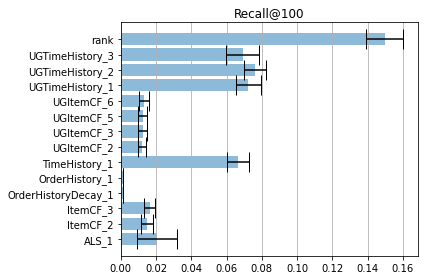

In [ ]:
## plot the results
x_pos = np.arange(len(method_cols))
labels = method_cols

fig, ax = plt.subplots()
ax.barh(x_pos, means,
        xerr =stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
       
ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.set_title('Recall@100')
ax.xaxis.grid(True)

plt.tight_layout()
plt.savefig('Recall@100.png')
plt.show()

Recall of 'rank' field (combination of all candidates) is much higher compared to individual candidate generation strategies. When we use multiple candidate generation techniques we can significantly increase recall - the potential of candidates.  

In [ ]:
# check the percentage of not nan values 
100 - new_candidates[method_cols].isnull().sum() * 100 / len(candidates)

method
ALS_1                   68.499536
ItemCF_2                66.478306
ItemCF_3                66.542712
OrderHistoryDecay_1     66.707244
OrderHistory_1          66.866466
TimeHistory_1           82.195648
UGItemCF_2              66.330758
UGItemCF_3              66.271445
UGItemCF_5              66.339293
UGItemCF_6              66.291213
UGTimeHistory_1         82.164245
UGTimeHistory_2         80.853346
UGTimeHistory_3         82.638221
rank                   100.000000
dtype: float64

82% of data was generated by 'TimeHistory_1' - popularity. At the same time these  candidates can be also generated bu other strategies so that the final score of these candidates is increasing. 

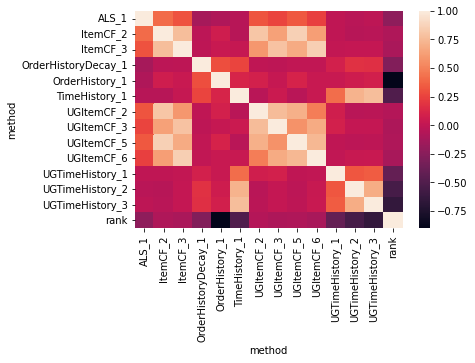

In [ ]:
# correlation between methods' scores 
import seaborn as sns
sns.heatmap(new_candidates[method_cols].corr())

Correlation is high between similar strategies but overall correlation is low. Correlation with rank (combined candidates) is low. It means that strategies may give different score to same candidates and the final rank is not defined by one specific strategy. 

### Feature generation 

For feature generation I used most of the funcitons from a notebook because they showed good performance at the final Kaggle competition. My goal was not to come up with new interesting features - I did not want to spend a lot of time for this process. 

In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
# merge full candidates to transaction data (avoid feature missing in training data)
full_candidates = []
for i in tqdm(range(1, WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{i}_candidate.pqt")
    full_candidates += candidate['article_id'].values.tolist()
full_candidates = list(set(full_candidates))
del candidate
gc.collect()

# generate pairs article_id - week for all candidates. 
num_candidates = len(full_candidates)
full_candidates = np.array(full_candidates)
full_candidates = np.tile(full_candidates, WEEK_NUM + 1)
weeks = np.repeat(np.arange(1,WEEK_NUM+2), num_candidates)
full_candidates = pd.DataFrame({'article_id':full_candidates, 'week':weeks})

# set 'valid' flag to real purchases from the history
inter['valid'] = 1
in_train = inter[inter['week']<=WEEK_NUM + 1]
out_train = inter[inter['week']>WEEK_NUM + 1]

# add my candidates to transaction dataset (including the whole history of transactions)
in_train = in_train.merge(full_candidates, on=['article_id','week'], how='right')
in_train['valid'] = in_train['valid'].fillna(0) # fill in 'valid' flag 
inter = pd.concat([in_train, out_train], ignore_index=True)
inter = inter.sort_values(["valid"], ascending=False).reset_index(drop=True)


100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


8

In [ ]:
# merge 'product_code'
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
# feature calculation: item unit sale in last n days (using valid=1 to count only real purchases)
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)


In [ ]:
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)


In [ ]:
# feature calculation: repurchase ratio of item units (using valid=1 to count only real purchases)
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'], week_num=WEEK_NUM)
inter, _ = reduce_mem_usage(inter)

100%|██████████| 7/7 [00:41<00:00,  5.88s/it]


In [ ]:
# feature calculation: week sales of each item unit
inter["i_sale"] = week_sale(inter, ["article_id"], week_num=WEEK_NUM)
inter["p_sale"] = week_sale(inter, ["product_code"], week_num=WEEK_NUM)
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True, week_num=WEEK_NUM)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True, week_num=WEEK_NUM)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1, week_num=WEEK_NUM) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1, week_num=WEEK_NUM)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1, week_num=WEEK_NUM)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1, week_num=WEEK_NUM)

# feature calculation: ratios 
inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no"
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale", week_num=WEEK_NUM)
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1, week_num=WEEK_NUM)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)



100%|██████████| 1/1 [00:09<00:00,  9.56s/it]


In [ ]:
# preparation for date related feature calculation: apply mask to purchases in future 
curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(100)}
current_dat = inter['week'].map(curr_date_dict)
mask = inter['valid']==0
inter.loc[mask, 't_dat'] = inter.loc[mask, 'week'].map(curr_date_dict)
first_date = inter.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
inter = pd.merge(inter, first_date, on='article_id', how='left')
inter['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(inter['first_dat'])).dt.days


In [ ]:
# feature calculation: cumulative sales of each item unit
inter['i_full_sale'] = full_sale(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_full_sale'] = full_sale(inter, ['product_code'], week_num=WEEK_NUM)

# other features generated based on calculated features 
inter['i_daily_sale'] = inter['i_full_sale'] / inter['first_dat']
inter['p_daily_sale'] = inter['p_full_sale'] / inter['first_dat']
inter['i_daily_sale_ratio'] = inter['i_daily_sale'] / inter['p_daily_sale']
inter['i_w_full_sale_ratio'] = inter['i_sale'] / inter['i_full_sale']

inter['i_2w_full_sale_ratio'] = inter['i_2w_sale'] / inter['i_full_sale']
inter['p_w_full_sale_ratio'] = inter['p_sale'] / inter['p_full_sale']
inter['p_2w_full_sale_ratio'] = inter['p_2w_sale'] / inter['p_full_sale']

inter['i_week_above_daily_sale'] = inter['i_sale'] / 7 - inter['i_daily_sale']
inter['p_week_above_full_sale'] = inter['p_sale'] / 7 - inter['i_full_sale']
inter['i_2w_week_above_daily_sale'] = inter['i_2w_sale'] / 14 - inter['i_daily_sale']
inter['p_2w_week_above_daily_sale'] = inter['p_2w_sale'] / 14 - inter['p_daily_sale']


In [ ]:
gc.collect()

0

In [ ]:
# other features generated based on calculated features 
for f in tqdm(item_feats):
    inter[f'{f}_full_sale'] = full_sale(inter, [f], week_num=WEEK_NUM)
    f_first_date = inter.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
    inter = inter.merge(f_first_date, on=f, how='left')
    inter[f'{f}_daily_sale'] = inter[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(inter[f'{f}_first_dat'])).dt.days
    inter[f'i_{f}_daily_sale_ratio'] = inter['i_daily_sale'] / inter[f'{f}_daily_sale']
    inter[f'p_{f}_daily_sale_ratio'] = inter['p_daily_sale'] / inter[f'{f}_daily_sale']
    del inter[f'{f}_full_sale'], inter[f'{f}_first_dat']
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

17

100%|██████████| 1/1 [00:21<00:00, 21.92s/it]


In [ ]:
# feature calculation: popularity factor of item unit.
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

In [ ]:
# truncate the dataset 
inter = inter.loc[inter['week'] <= WEEK_NUM + 2]

In [ ]:
# example of dataset
inter[inter['week'] == 1]

,t_dat,customer_id,article_id,price,sales_channel_id,week,valid,product_code,i_1w_sale_rank,i_1w_sale_norm,...,p_2w_full_sale_ratio,i_week_above_daily_sale,p_week_above_full_sale,i_2w_week_above_daily_sale,p_2w_week_above_daily_sale,product_type_no_daily_sale,i_product_type_no_daily_sale_ratio,p_product_type_no_daily_sale_ratio,i_pop,p_pop
3597927,2020-09-17,490012,2,0.008458,2,1,1,1,11340,0.000009,...,0.018182,-0.892447,-204.714286,-8.924466e-01,-0.978654,2172.485714,0.000542,0.000582,2.893641,3.017768
4663585,2020-09-22,1257240,81558,0.042356,2,1,1,34446,137,0.000746,...,0.731801,18.452381,-298.285714,1.652381e+01,37.142857,5150.125714,0.001604,0.006033,97.045105,210.537021
4663586,2020-09-22,300118,81609,0.033881,2,1,1,34465,151,0.000720,...,0.110458,9.547619,-369.571429,1.419048e+01,-94.833333,4644.862857,0.002097,0.030536,77.924714,210.731787
4663587,2020-09-22,265054,81609,0.033881,2,1,1,34465,151,0.000720,...,0.110458,9.547619,-369.571429,1.419048e+01,-94.833333,4644.862857,0.002097,0.030536,77.924714,210.731787
4663588,2020-09-22,161691,81609,0.033881,2,1,1,34465,151,0.000720,...,0.110458,9.547619,-369.571429,1.419048e+01,-94.833333,4644.862857,0.002097,0.030536,77.924714,210.731787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160510,2020-09-23,0,101388,-0.999864,0,1,0,44533,-9223372036854775808,-0.999998,...,0.003546,-0.341040,-59.000000,-6.588123e+17,-1.558629,5150.125714,0.000066,0.000317,0.498026,2.812027
7160519,2020-09-23,0,101387,-0.999864,0,1,0,44533,-9223372036854775808,-0.999998,...,0.003546,-0.439306,-76.000000,-6.588123e+17,-1.558629,5150.125714,0.000085,0.000317,0.880633,2.812027
7160683,2020-09-23,0,101386,-0.999864,0,1,0,44533,19357,0.000002,...,0.003546,-0.404624,-70.000000,-3.331957e-01,-1.558629,5150.125714,0.000079,0.000317,0.825202,2.812027
7160702,2020-09-23,0,101382,-0.999864,0,1,0,44531,19357,0.000002,...,0.142857,-0.125000,-7.000000,-5.357143e-02,-0.053571,211.245714,0.000592,0.000592,0.301417,0.301417


In [ ]:
# save transaction dataset 
# inter.to_parquet(data_dir / "processed/processed_inter.pqt") # write to a file 
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt") # read from a file 


### Merge features to candidates and create a dataset for training and validation  

#### Sanity check

In [ ]:
## Dataset validy check 
i = 2 # week number 
candidate2 = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{i}_candidate.pqt")

# merge features and add 'label' flag for future purchases 
candidate2 = merge_week_data(data, inter, i, candidate2)
print(candidate2['week'].unique())
# candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{i}_candidate.pqt")


72019
[2]


In [ ]:
candidate2.shape

(7269594, 103)

In [ ]:
# drop some columns that are not imformative 
candidate2.drop(columns=['i_daily_sale_ratio',
 'i_w_full_sale_ratio',
 'p_w_full_sale_ratio',
 'i_product_type_no_daily_sale_ratio',
 'p_product_type_no_daily_sale_ratio'], inplace=True)

In [ ]:
# check for nans in a dataset
candidate2.columns[candidate2.isna().any()].tolist()

['ALS_1',
 'ItemCF_2',
 'ItemCF_3',
 'OrderHistoryDecay_1',
 'OrderHistory_1',
 'TimeHistory_1',
 'UGItemCF_2',
 'UGItemCF_3',
 'UGItemCF_5',
 'UGItemCF_6',
 'UGTimeHistory_1',
 'UGTimeHistory_2',
 'UGTimeHistory_3',
 'score',
 'rank']

We see nans only in columns that are responsible for candidate generation steps. These nans mean that a pair was not generated, but in the next week it was actually bought.  

#### Merge features for all candidates 
For records I used all the bought items (not only ones from candidate generation step). 

In [ ]:
for i in tqdm(range(1, WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"new_week{i}_candidate.pqt")

    # merge features
    candidate = merge_week_data(data, inter, i, candidate)
    print(candidate['week'].unique())
    candidate.drop(columns=['i_daily_sale_ratio', 'i_w_full_sale_ratio', 'p_w_full_sale_ratio', 
                             'i_product_type_no_daily_sale_ratio', 'p_product_type_no_daily_sale_ratio'], inplace=True)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{i}_candidate.pqt")


  0%|          | 0/5 [00:00<?, ?it/s]

68984
[ 1. nan]


 20%|██        | 1/5 [02:04<08:19, 124.77s/it]

72019
[2]


 40%|████      | 2/5 [03:36<05:16, 105.33s/it]

75822
[3]


 60%|██████    | 3/5 [05:13<03:22, 101.34s/it]

80253
[4]


 80%|████████  | 4/5 [06:55<01:41, 101.85s/it]

72035
[5]


100%|██████████| 5/5 [08:30<00:00, 102.09s/it]


# Ranker creation

#### Useful functions and constants 

In [ ]:
# feature lists 
int_features = ['age', 'i_1w_sale_rank', 'p_1w_sale_rank', 'i_2w_sale_rank', 'p_2w_sale_rank','i_3w_sale_rank', 'p_3w_sale_rank', 'i_4w_sale_rank',
                'p_4w_sale_rank', 'i_2w_sale', 'p_2w_sale','i_3w_sale', 'p_3w_sale','i_4w_sale', 'p_4w_sale','i_sale', 'p_sale', 'i_sale_uni', 'p_sale_uni',
       'lw_i_sale', 'lw_p_sale', 'lw_i_sale_uni', 'lw_p_sale_uni','first_dat', 'i_full_sale', 'p_full_sale','product_type_no_sale', 'lw_product_type_no_sale']

float_features = ['i_repurchase_ratio',
       'p_repurchase_ratio', 
       'i_sale_ratio', 'i_sale_uni_ratio', 'lw_i_sale_ratio',
       'lw_i_sale_uni_ratio', 'i_uni_ratio', 'p_uni_ratio', 'lw_i_uni_ratio',
       'lw_p_uni_ratio', 'i_sale_trend', 'p_sale_trend',  
       'product_type_no_sale_trend', 
       'i_daily_sale', 'p_daily_sale', 'i_2w_full_sale_ratio',
       'p_2w_full_sale_ratio', 'i_week_above_daily_sale',
       'p_week_above_full_sale', 'i_2w_week_above_daily_sale',
       'p_2w_week_above_daily_sale', 'product_type_no_daily_sale', 'i_pop', 'p_pop']
cat_features_user = ['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'user_gender']
cat_features_item = ['product_code', 'article_gender', 'season_type']

cat_features = cat_features_user + cat_features_item
features = int_features + float_features + cat_features

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "verbose": -1,
    "eval_at": 12,
}

In [ ]:
# dictionary creation for categorical features based on full dataset  
cate_dict = {}        
for feat in tqdm(cat_features_user):
    print(feat)
    value_set = set(data['user'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

for feat in tqdm(cat_features_item):
    print(feat)
    value_set = set(data['item'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)


100%|██████████| 5/5 [00:00<00:00, 91.90it/s]


FN
Active
club_member_status
fashion_news_frequency
user_gender


100%|██████████| 3/3 [00:00<00:00, 85.60it/s]

product_code
article_gender
season_type


In [ ]:
def train_binary_model(train, 
                       valid, 
                       feats,
                       params,
                       name,
                       target='label', 
                       cat_features=cat_features):
  
    """ Train a ranker (lgb classifier) and save it to disk.
    Parameters
    ----------
    train : pd.DataFrame
        Dataframe of pairs for training.
    valid : pd.DataFrame
        Dataframe of pairs for validation.
    feats : List
        List of model features.
    params : List
        List of model parameters.
    name : String
        Name of a model for saving.
    target : String, optional
        Target field name, by default ``label``.
    cat_features: List, optional
        List of categorical features for a model, by default predefined list is used. 

    Returns
    -------
    lgb.booster
        Trained model.
    """

    train_set = lgb.Dataset(
        data=train[feats],
        label=train[target],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid[target],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )
    # eval results for plotting
    evals_result = {} 
    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=100,
        valid_sets=[train_set, valid_set],
        early_stopping_rounds=20,
        verbose_eval=10,
        evals_result=evals_result,
    )
    print('Plot metrics during training...')
    ax = lgb.plot_metric(evals_result, metric='auc')
    plt.show()
    ranker.save_model(
        model_dir/f"lgb_large_ranker_{name}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

def select_n_candidates(res, n, grouped=False, name='score'): 
    """ Rank candidate and select top n.
    Parameters
    ----------
    res : pd.DataFrame
        Dataframe with pairs.
    n : int
        Number of returned candidates.
    grouped : bool, optional
        Whether to group articles for customers in one list, by default ``False``.
    name : String, optional
        Name of a field that is used for ranking, by default ``score``.
    
    Returns
    -------
    pd.DataFrame
        Dataframe with top n candidates for every customer in dataframe.
    """
    res['rank_'] = res.groupby('customer_id')[name].rank(ascending=False, method='first')
    res = res[res['rank_'] <= n]
    if grouped:
        res = (res.groupby(["customer_id"])['article_id'].apply(list).reset_index())
    return res

def train_model(train, valid, name, features, params, plot_imp=True):
    """ Train a model.
    Parameters
    ----------
    train : pd.DataFrame
        Dataframe of pairs for training.
    valid : pd.DataFrame
        Dataframe of pairs for validation.
    name : String
        Name of a model for saving.
    features : List
        List of model features.
    params : List
        List of model parameters.
    plot_imp : bool, optional
        Whether to plot feature importance, by default ``True``.

    Returns
    -------
    lgb.booster
        Trained model.
    """
    print('Train positive rate: ', train.label.mean())
    ranker = train_binary_model(train, valid, features, params, name=name)
    if plot_imp:
      feat_importance = pd.DataFrame( {"feature": features, "importance": ranker.feature_importance()}).sort_values(by="importance", ascending=False)
      plt.figure(figsize=(8, 10))
      sns.barplot(y="feature", x="importance", data=feat_importance)
    return ranker


def train_split_valid(p, candidate, val_candidate, val_candidate_cand, val_label, name, features, params):
    """ Train a model and calculate MAP@12 on validation data.
    Parameters
    ----------
    p : float
        Percentage of data to be inclused.
    candidate : pd.DataFrame
        Dataframe of pairs for training.
    val_candidate : pd.DataFrame
        Dataframe of pairs for validation during training.
    val_candidate_cand : pd.DataFrame
        Dataframe of pairs for validation (inclusing only candidates with real purchases). The one that should be scored.
    val_label : pd.DataFrame
        Dataframe with actual purchases in the next week for MAP@12 calculation. 
    name : String
        Name of a model for saving.
    features : List
        List of model features.
    params : List
        List of model parameters.
    
    Returns
    -------
    """
    n_sample = int(candidate.shape[0] * p) # calculate the number of samples for training 
    sample_candidate=candidate.sample(n=n_sample, axis=0) # generate sample for training 
    sample_candidate_val=val_candidate.sample(n=n_sample, axis=0)  # generate sample for validation 
    print(sample_candidate.shape)
    ranker = train_model(sample_candidate, sample_candidate_val, name, features, params, plot_imp=True)

    # MAP@12 calculation for model results 
    val_candidate_cand['pred'] = ranker.predict(val_candidate_cand[features])
    top12 = select_n_candidates(val_candidate_cand, 12, grouped=True, name='pred')
    map = mean_average_precision(y_true=val_label['article_id'], y_pred=top12['article_id'])
    print("MAP@12: ", map)

#### Parameters for training 

In [ ]:
# was run for cv = [0, 1, 2]
cv = 2 # cross-validation number : [0,1,2] - training and validation on three different runs 
val_week = cv + 1 # one week was used for validation 
# train_week = [val_week+1, val_week+2] # tried to used two weeks for training but it took too much memory  
train_week = [val_week+1] # so one week was used for training

candidate = pd.DataFrame()
for week in train_week:
  candidate = candidate.append(pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{week}_candidate.pqt"))

val_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{val_week}_candidate.pqt")
val_label = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{val_week}_label.pqt")


In [ ]:
print(candidate.shape)
print(candidate['label'].mean()) # high positive rate because all of the future purchases are included 

(8063414, 98)
0.0316456528214972


In [ ]:
print(candidate[candidate['rank'] >= 0].shape)
print(candidate[candidate['rank'] >= 0]['label'].mean()) # much lower positive rate because only candidates are included 

(7841155, 98)
0.004197468357659044


In [ ]:
# use only 50 candidates per customer
val_candidate = val_candidate[val_candidate['rank'] <= 50]  
candidate = candidate[candidate['rank'] <= 50]

print(candidate[candidate['rank'] >= 0].shape)
print(candidate[candidate['rank'] >= 0]['label'].mean()) # a bit higher positive rate because less candidates are included 

(4011622, 98)
0.005448918168262115


In [ ]:
# rename columns 
candidate.rename(columns={'product_type_no_x': 'product_type_no'}, inplace=True)
val_candidate.rename(columns={'product_type_no_x': 'product_type_no'}, inplace=True)

In [ ]:
# validity check 
val_candidate = val_candidate[val_candidate['week'] == val_week]

In [ ]:
# feature transformation based on its type for training dataset 
candidate[int_features] = candidate[int_features].astype(int)
candidate[float_features] = candidate[float_features].astype(float)

for feat in tqdm(cat_features):
    candidate[feat] = candidate[feat].astype(cate_dict[feat])

100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


In [ ]:
# feature transformation based on its type for validation dataset 
val_candidate[int_features] = val_candidate[int_features].astype(int)
val_candidate[float_features] = val_candidate[float_features].astype(float)

for feat in tqdm(cat_features):
    val_candidate[feat] = val_candidate[feat].astype(cate_dict[feat])


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


In [ ]:
# select only records with future purchases for scoring and results 
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]


### Baseline 

In [ ]:
# rank based on 'score' - combined score from candidate generation strategies 
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
top12 = select_n_candidates(val_candidate_cand, 12, grouped=True, name='score')
map = mean_average_precision(y_true=val_label['article_id'], y_pred=top12['article_id']) ### 0.008126320505691766
print(cv, map)

### Part 1
Positive sampling exploration

In [ ]:
# train with all future purchases 
p = 0.1 # percentage of training data to be used for training and validation 
name = str(p) + str(cv) + "all_purchases"
train_split_valid(p, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

MAP@12:  0.008105678715709873


In [ ]:
# train only with candidates - without all future purchases  
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.1
name = str(p) + str(cv) + "candidates_only"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

MAP@12:  0.009964116727273518


In [ ]:
print("Train positive rate:", candidate_cand.label.mean())
# Ignore customers with full negative samples
candidate_cand['customer_id'] = candidate_cand['customer_id'].astype(int)
valid_uids = candidate_cand.groupby('customer_id')['label'].sum().reset_index(name='sum')
candidate_cand = candidate_cand[candidate_cand['customer_id'].isin(valid_uids.loc[valid_uids['sum'] > 0, 'customer_id'])]
print("Train positive rate:", candidate_cand.label.mean())

Train positive rate: 0.005448918168262115
Train positive rate: 0.024822819869611778


In [ ]:
# train only with candidates with future purchases   
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.1
name = str(p) + str(cv) + "pos_candidates_only"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

MAP@12:  0.011013494233021382


In [ ]:
# add extra features from candidate generation step to a list of predictors 
features = features + ['rank', 'score']

In [ ]:
# train only with candidates with future purchases and extra features
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.1
name = str(p) + str(cv) + "pos_candidates_only_feature"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

MAP@12:  0.014186250682127192


In [ ]:
# add extra parameters 
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
}

In [ ]:
# train only with candidates with future purchases, extra features and parameters  
# later the same sets of predictors and parameters are used for different negative sampling strategies 
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.1
name = str(p) + str(cv) + "pos_candidates_only_feature_pred"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

In [ ]:
# negative sampling with 20% of data  
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.2
name = str(p) + str(cv) + "pos_candidates_only_feature_pred"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

In [ ]:
# negative sampling with 30% of data  
val_candidate_cand = val_candidate[val_candidate['score'].notna()]
candidate_cand = candidate[candidate['score'].notna()]

p = 0.3
name = str(p) + str(cv) + "pos_candidates_only_feature_pred"
train_split_valid(p, candidate_cand, val_candidate_cand, val_candidate_cand, val_label, name, features, params)

In [ ]:
# weighted model  - negative sampling with positive sample rate = 50%
sample_candidate=candidate_cand[candidate_cand['label'] == 1]
n_sample = int(sample_candidate.shape[0])
sample_candidate=sample_candidate.append(candidate_cand[candidate_cand['label'] == 0].sample(n=n_sample, axis=0))

sample_candidate_val=val_candidate_cand[val_candidate_cand['label'] == 1]
n_sample = int(sample_candidate_val.shape[0])
sample_candidate_val=sample_candidate_val.append(val_candidate_cand[val_candidate_cand['label'] == 0].sample(n=n_sample, axis=0))

ranker = train_model(sample_candidate, sample_candidate_val, str(cv) + "5050candidates_only_perc", features, params, plot_imp=True)


In [ ]:
val_candidate_cand['pred'] = ranker.predict(val_candidate_cand[features])
top12 = select_n_candidates(val_candidate_cand, 12, grouped=True, name='pred')
map = mean_average_precision(y_true=val_label['article_id'], y_pred=top12['article_id'])

print("MAP@12: ", map)

### Part 2 
Negative samples are generated based on one of candidate generation strategies. 
Features, parameters are the same as were used for previous experiments. Balanced model (positive rate = 50%) is used. 

In [ ]:

def train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params):
    """ Train a model and calculate MAP@12 on validation data.
    Sample generation is based on sampling from one strategy of candidate generation.
    Parameters
    ----------
    field_name : string
        Name of the candidate generation strategy to select candidates from.
    candidate : pd.DataFrame
        Dataframe of pairs for training.
    val_candidate : pd.DataFrame
        Dataframe of pairs for validation during training.
    val_candidate_cand : pd.DataFrame
        Dataframe of pairs for validation (inclusing only candidates with real purchases). The one that should be scored.
    val_label : pd.DataFrame
        Dataframe with actual purchases in the next week for MAP@12 calculation. 
    name : String
        Name of a model for saving.
    features : List
        List of model features.
    params : List
        List of model parameters.
    
    Returns
    -------
    """
    sample_candidate=candidate[candidate['label'] == 1]
    n_sample = int(sample_candidate.shape[0])
    sample_candidate=sample_candidate.append(candidate[candidate['label'] == 0].sample(n=n_sample, weights=field_name, axis=0))

    sample_candidate_val=val_candidate[val_candidate['label'] == 1]
    n_sample = int(sample_candidate_val.shape[0])
    sample_candidate_val=sample_candidate_val.append(val_candidate[val_candidate['label'] == 0].sample(n=n_sample, weights=field_name, axis=0))

    ranker = train_model(sample_candidate, sample_candidate_val, name, features, params, plot_imp=True)

    # MAP@12 calculation for model results 
    val_candidate_cand['pred'] = ranker.predict(val_candidate_cand[features])
    top12 = select_n_candidates(val_candidate_cand, 12, grouped=True, name='pred')
    map = mean_average_precision(y_true=val_label['article_id'], y_pred=top12['article_id'])
    print("MAP@12: ", map)

Train positive rate:  0.5
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.760281	valid_1's auc: 0.567255
[20]	training's auc: 0.764922	valid_1's auc: 0.556002
Early stopping, best iteration is:
[8]	training's auc: 0.759432	valid_1's auc: 0.581938
Plot metrics during training...


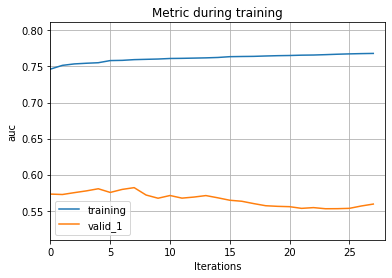

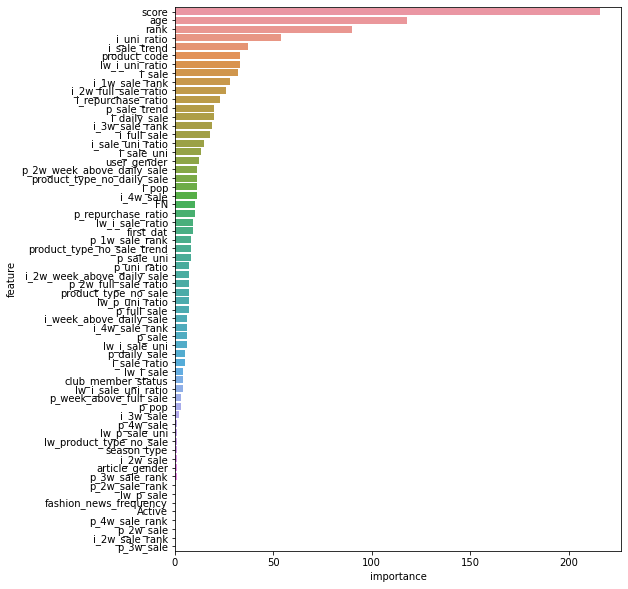

In [ ]:
# generate negative samples based on combined score
field_name = 'score'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
# generate negative samples based on ALS_1 strategy
field_name = 'ALS_1'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
# generate negative samples based on ItemCF_2 strategy
field_name = 'ItemCF_2'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
# generate negative samples based on ItemCF_3 strategy
field_name = 'ItemCF_3'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
# generate negative samples based on TimeHistory_1 strategy
field_name = 'TimeHistory_1'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
# generate negative samples based on UGTimeHistory_1 strategy
field_name = 'UGTimeHistory_1'
name = str(cv) + str(field_name) + "weight_5050candidates_only"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)

In [ ]:
features.remove('score')
features.remove('rank')

Train positive rate:  0.5
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.82769	valid_1's auc: 0.687351
[20]	training's auc: 0.829236	valid_1's auc: 0.698689
[30]	training's auc: 0.829322	valid_1's auc: 0.700255
[40]	training's auc: 0.829561	valid_1's auc: 0.695646
Early stopping, best iteration is:
[25]	training's auc: 0.829261	valid_1's auc: 0.701583
Plot metrics during training...


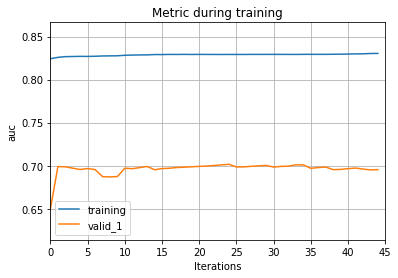

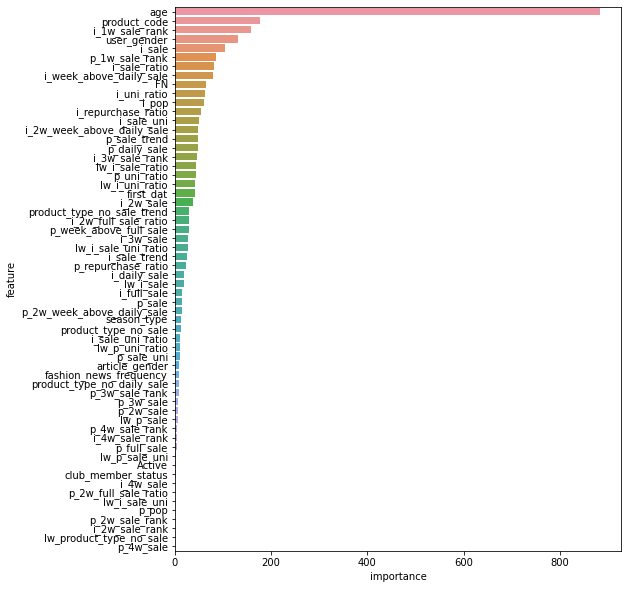

In [ ]:
# generate negative samples based on UGTimeHistory_1 strategy without two predictors 
field_name = 'UGTimeHistory_1'
name = str(cv) + str(field_name) + "weight_5050candidates_only_pred"
train_split_valid_sampled(field_name, candidate, val_candidate, val_candidate_cand, val_label, name, features, params)
# worse result 

### Part 3 
Model stacking - results from 6 models are stacked together with weights. 

In [ ]:
def read_val_candidates(cv):
    """ Read candidates for validation with all the final settings.  
    Parameters
    ----------
    cv : int 
        Number of cross-validation run.
    Returns
    -------
    pd.DataFrame 
        Validation dataset.
    pd.DataFrame 
        Dataframe with validation labels.
    """

    val_week = cv + 1 # one week was used for validation 

    val_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{val_week}_candidate.pqt")
    val_label = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"new_week{val_week}_label.pqt")

    # use only 50 candidates per customer
    val_candidate = val_candidate[val_candidate['rank'] <= 50]  

    # rename columns 
    val_candidate.rename(columns={'product_type_no_x': 'product_type_no'}, inplace=True)

    # validity check 
    val_candidate = val_candidate[val_candidate['week'] == val_week]

    # feature transformation based on its type for validation dataset 
    val_candidate[int_features] = val_candidate[int_features].astype(int)
    val_candidate[float_features] = val_candidate[float_features].astype(float)

    for feat in tqdm(cat_features):
        val_candidate[feat] = val_candidate[feat].astype(cate_dict[feat])

    # select only records with future purchases for scoring and results 
    val_candidate_cand = val_candidate[val_candidate['score'].notna()]
    return val_candidate_cand, val_label

In [ ]:
# was run for cv = [0, 1, 2]
cv = 2 # define cv value 
val_candidate_cand, val_label = read_val_candidates(cv)
names = ['score', 'ALS_1', 'ItemCF_2', 'ItemCF_3', 'TimeHistory_1', 'UGTimeHistory_1']
pred_names = []
for name in names:
  print(name)
  filename = 'lgb_large_ranker_' + str(cv) + str(name) + 'weight_5050candidates_only.model'
  ranker = lgb.Booster(model_file=model_dir/filename)
  val_candidate_cand[name + '_pred'] = ranker.predict(val_candidate_cand[ranker.feature_name()])
  pred_names.append(name + '_pred')

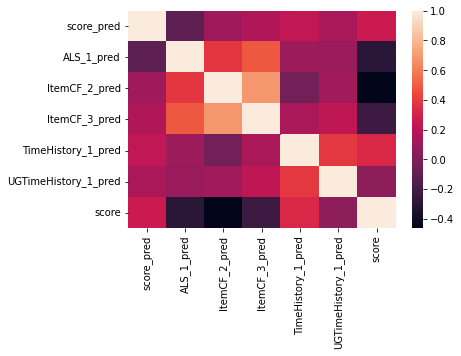

In [ ]:
sns.heatmap(val_candidate_cand[pred_names+['score']].corr())

Combination of 6 models is based on their performance. From previous runs we know that 'ItemCF_2' and 'ItemCF_3' show worse performance so weight 0.1 is assigned to them. For other models weight of 0.2 is used. All the weights are summed up to 1. Additionally, score is used because baseline shows quite good result just by itself. 

In [ ]:
weights = pd.Series([0.2, 0.2, 0.1, 0.1, 0.2, 0.2], index=pred_names)
tmp = val_candidate_cand[pred_names + ['article_id', 'customer_id', 'score']]

tmp['weighted'] = (tmp * weights).sum(1) + tmp['score']

In [ ]:
# MAP@12 calculation 
top12 = select_n_candidates(tmp, 12, grouped=True, name='weighted')
map = mean_average_precision(y_true=val_label['article_id'], y_pred=top12['article_id'])

print("MAP@12: ", map)

MAP@12:  0.012209506630524638
